# Categorize Documents

In [204]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

## Useful Links

### Scikit-Learn
[Scikit-Learn Documentation](http://scikit-learn.org/stable/user_guide.html)

### NLTK
[NLTK Book](http://www.nltk.org/book/)  
[NLTK API DOCS](http://www.nltk.org/api/nltk.html)  
[Module Index](http://www.nltk.org/py-modindex.html)

## Exploratory Analysis

In [162]:
df = pd.read_csv("newtrain.csv")
df_train = pd.read_csv("training.csv")
df_dev = pd.read_csv("dev_testing.csv")
df_train.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,3,what was the first dvd you ever bought? what w...


Looks like class labels are disproportionately represented.  
*Possible actions*: different samples methods (stratified), make up more data, etc

### Class Count

<Container object of 7 artists>

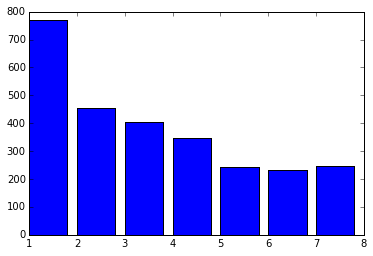

In [210]:
count_by_category = df.groupby("Category").count()
plt.bar(count_by_category.index, count_by_category["Text"])

### Text Length by Class

          Text Length
Category             
1           74.023407
2           97.407489
3           79.928571
4           94.527378
5           80.471311
6           85.396552
7           71.447154


<Container object of 7 artists>

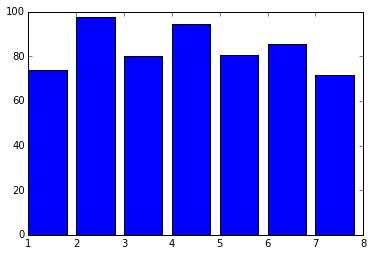

In [222]:
df["Text Length"] = list(map(len, df["Text"]))
text_len_by_category = df.groupby("Category").mean()
print(text_len_by_category)
plt.bar(text_len_by_category.index, text_len_by_category["Text Length"])

          Text Length  Avg Word Length
Category                              
1           74.023407         4.320244
2           97.407489         4.487747
3           79.928571         4.505012
4           94.527378         4.033073
5           80.471311         4.595287
6           85.396552         4.349611
7           71.447154         4.548233


<Container object of 7 artists>

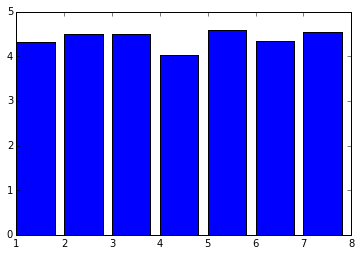

In [230]:
df["Avg Word Length"] = list(map(lambda x: np.mean(list(map(len, x.split()))), df["Text"]))
avg_word_len_by_class = df.groupby("Category").mean()
print(avg_word_len_by_class)
plt.bar(avg_word_len_by_class.index, avg_word_len_by_class["Avg Word Length"])

## Feature Extraction

### Helper Functions

In [164]:
# Figure out the best feature extraction to use: http://scikit-learn.org/stable/modules/feature_extraction.html

def to_tokens(txt):
    pattern = r'''(?x)    # set flag to allow verbose regexps
        <
        | :
        | ([A-Z]\.)+        # abbreviations, e.g. U.S.A.
       | \w+([-']\w+)*        # words with optional internal hyphens
       | \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
       | \.\.\.            # ellipsis
       | [.,;"'?():-_`]+  # these are separate tokens
     '''
    return nltk.regexp_tokenize(txt, pattern)

def remove_stopwords(wrds):
    stop_words = nltk.corpus.stopwords.words('english')
    return list(filter(lambda w: w.lower() not in stop_words, wrds))

def remove_punctuation(wrds):
    exclude = list(string.punctuation) + ["--","...", "`"]
    return list(filter(lambda w: w[0] not in exclude, wrds))

def remove_digits(wrds):
    exclude = list(string.digits)
    return list(filter(lambda w: w[0] not in exclude, wrds))

### Generate Features

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=4, stop_words="english", ngram_range=(1,2), max_features=1000)
df_features = vectorizer.fit_transform(df["Text"]).toarray()
# train_features = vectorizer.fit_transform(df_train["Text"]).toarray()
dev_features = vectorizer.transform(df_dev["Text"]).toarray()

## Models

### Naive Bayes

In [201]:
nb = MultinomialNB()
nb_model = nb.fit(train_features, df_train["Category"])
nb_predictions = nb_model.predict(dev_features)

accuracy_score(df_dev["Category"], nb_predictions)

0.4857849196538937

In [209]:
parameters = {"alpha": [0.0, 0.5, 1.0], "fit_prior": [True, False]}
clf = GridSearchCV(nb, parameters)
clf.fit(train_features, df_train["Category"])

<bound method GridSearchCV.score of GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'fit_prior': [True, False], 'alpha': [0.0, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)>


### SVM

In [198]:
svm = SVC(C=1000000.0, gamma=0.0, kernel='rbf')
svm_model = svm.fit(train_features, df_train["Category"])
svm_predictions = svm_model.predict(dev_features)

accuracy_score(df_dev["Category"], svm_predictions)

0.4264524103831891

### Gradient Boosting

In [243]:
gb = GradientBoostingClassifier()
gb_model = gb.fit(df_features, df["Category"])
gb_predictions = gb_model.predict(dev_features)

accuracy_score(df_dev["Category"], gb_predictions)

0.72435105067985162

## Evaluation

### Confusion Matrix

In [238]:
y_true = pd.Series(df_dev["Category"])
y_pred = pd.Series(nb_predictions)

print(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

y_true = pd.Series(df_dev["Category"])
y_pred = pd.Series(gb_predictions)

print(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted    1    2   3   4   5   6   7  All
True                                        
1          184   24   8  10   1   3   2  232
2           61   73   2   0   0   0   2  138
3           59    8  50   8   0   0   1  126
4           49    0   2  60   0   0   2  113
5           51    6   7   2   8   0   0   74
6           40    1   0   6   0   9   2   58
7           44    4   3   4   1   3   9   68
All        488  116  72  90  10  15  18  809
Predicted    1   2   3    4   5   6   7  All
True                                        
1          162  18   7   20  13   4   8  232
2           55  64   6    1   2   1   9  138
3           52   3  54   10   4   0   3  126
4           37   0   1   68   1   3   3  113
5           51   2   2    2  15   1   1   74
6           33   2   0    7   1   9   6   58
7           39   4   1    1   4   3  16   68
All        429  93  71  109  40  21  46  809


In [182]:
print("Actual", "Predicted", "Text", sep="-")
for i in range(0, len(df_dev)):
    if df_dev.ix[i]["Category"] != svm_predictions[i]:
        print(df_dev.ix[i]["Category"], svm_predictions[i], df_dev.ix[i]["Text"], sep="-")

Actual-Predicted-Text
3-1-garfield
5-1-what is the best way to learn history?
3-5-who was famous for the line nanoo nanoo?
7-1-can you please help me pass my psychology test? discuss the criteria for determining abnormality.
2-3-what are the most popular blogging tools? what are the market shares of the top 10 blogging packages / asps?
3-1-who was the first superman?
2-1-what is adsense?
5-1-what are the seven sisters schools? are they considered as good colleges?
1-2-i can't find my answer to my security question so i can get my password? i am using my girlfriends email address to talk to you guys somebody that knows my information keeps changing my password and security answer and she has changed it again i can't access my account because i don't know my security answer please help my name is david_saxby@yahoo.com my birthdate is march 19 1976 i live in the united states and my zip code is 45648 please email me at natalie_tackett2003@yahoo.com with the answers thank you
1-7-how is ve

## Prediction of the Test Set

In [101]:
df_test = pd.read_csv("newtest.csv")
dev_features = vectorizer.transform(df_test["Text"]).toarray()
nb_predictions = nb_model.predict(dev_features)
predictions = list(zip(df_test["Id"], nb_predictions))
predictions = pd.DataFrame(predictions)
predictions.columns = ["Id", "Category"]
predictions.to_csv("submission1.csv", index=False)

In [244]:
df_test = pd.read_csv("newtest.csv")
dev_features = vectorizer.transform(df_test["Text"]).toarray()
gb_predictions = gb_model.predict(dev_features)
predictions = list(zip(df_test["Id"], gb_predictions))
predictions = pd.DataFrame(predictions)
predictions.columns = ["Id", "Category"]
predictions.to_csv("submission2.csv", index=False)